Import


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bc = pd.read_csv('seatle.csv')

## Selection des batiments non residentiels

In [66]:
print(f"Nombre totale de batiments: {len(bc)}")
bc = bc[~bc['BuildingType'].str.contains('Multifamily', na=False)]
print(f"Nombre de batiments non residentiels: {len(bc)}")

Nombre totale de batiments: 3376
Nombre de batiments non residentiels: 1668


# TRAITEMENT DES COLONNES ET DES LIGNES

## Suppression des colonnes vides, avec des données manquantes, à zéro ou constantes
- Comments : Colonne vide
- Outlier : Valeurs manquantes
- YearsENERGYSTARCertified : Valeurs manquantes
- ThirdLargestPropertyUseType : Valeurs manquantes
- ThirdLargestPropertyUseTypeGFA : Valeurs manquantes
- SecondLargestPropertyUseType : Valeurs manquantes
- SecondLargestPropertyUseTypeGFA : Valeurs manquantes
- ENERGYSTARScore : Valeurs manquantes
- DataYear, City, State : Valeurs constantes
- OSEBuildingID, PropertyName, Address, TaxParcelIdentificationNumber, LargestPropertyUseType, LargestPropertyUseTypeGFA, DefaultData, CouncilDistrictCode, Latitude, Longitude : Valeurs non pertinentes,

In [67]:
print(f"Colonnes: {bc.shape[1]}")

bc.isnull().sum().sort_values(ascending=False)
# Suppression des colonnes avec plus de 500 données manquantes
bc = bc.loc[:, bc.isnull().sum() <= 500]
bc.isnull().sum().sort_values(ascending=False)

# Suppression des colonnes avec des données constantes
bc.columns[bc.nunique() == 1].tolist()
bc.drop((['DataYear','City','State']), axis=1, inplace=True)

# Suppression des colonnes non pertinentes
bc.drop((['OSEBuildingID','PropertyName','Address','TaxParcelIdentificationNumber','LargestPropertyUseType','LargestPropertyUseTypeGFA','DefaultData','CouncilDistrictCode','Latitude','Longitude']), axis=1, inplace=True)

# Suppression des colonnes avec des valeurs à 0
(bc == 0).sum().sort_values(ascending=False)
bc.drop((['SteamUse(kBtu)']), axis=1, inplace=True)

print(f"Colonnes: {bc.shape[1]}")

Colonnes: 46
Colonnes: 24


## Suppression des lignes avec des données manquantes

In [68]:
bc.isnull().sum().sort_values(ascending=False)
bc.dropna(subset=['SiteEUI(kBtu/sf)'], inplace=True)
bc.dropna(subset=['SiteEUIWN(kBtu/sf)'], inplace=True)
bc.isnull().sum().sort_values(ascending=False)

ZipCode                      16
BuildingType                  0
SourceEUI(kBtu/sf)            0
TotalGHGEmissions             0
ComplianceStatus              0
NaturalGas(kBtu)              0
NaturalGas(therms)            0
Electricity(kBtu)             0
Electricity(kWh)              0
SiteEnergyUseWN(kBtu)         0
SiteEnergyUse(kBtu)           0
SourceEUIWN(kBtu/sf)          0
SiteEUIWN(kBtu/sf)            0
PrimaryPropertyType           0
SiteEUI(kBtu/sf)              0
ListOfAllPropertyUseTypes     0
PropertyGFABuilding(s)        0
PropertyGFAParking            0
PropertyGFATotal              0
NumberofFloors                0
NumberofBuildings             0
YearBuilt                     0
Neighborhood                  0
GHGEmissionsIntensity         0
dtype: int64

## Traitement des quartiers
- Certains quartiers sont en minuscules et 1 quartier "DELRIDGE NEIGHBORHOODS" peut etre modifié en "DELRIDGE"

In [69]:
print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

# Mettre les valeurs en MAJUSCULE
bc['Neighborhood'] = bc['Neighborhood'].str.upper()

# Modifier le quartier "DELRIDGE NEIGHBORHOODS")" en "DELRIDGE"
bc.loc[bc['Neighborhood'] == "DELRIDGE NEIGHBORHOODS", 'Neighborhood'] = "DELRIDGE"

print(bc.groupby(['Neighborhood']).size().sort_values(ascending=False))

Neighborhood
DOWNTOWN                  358
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     151
LAKE UNION                148
NORTHEAST                 127
EAST                      121
NORTHWEST                  81
BALLARD                    64
NORTH                      58
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  41
North                       9
Ballard                     6
Central                     5
Northwest                   5
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
dtype: int64
Neighborhood
DOWNTOWN                 358
GREATER DUWAMISH         346
MAGNOLIA / QUEEN ANNE    151
LAKE UNION               148
NORTHEAST                127
EAST                     121
NORTHWEST                 86
BALLARD                   70
NORTH                     67
CENTRAL                   56
DELRIDGE                  47
SOUTHEAST                 46
SOUTHWEST                 41
dtype: int64


## Traitement des codes postaux
- Sur les ZIPCODE manquants, on peut récupérer le quartier et ajouter le ZIPCODE le plus probable.

In [70]:
######## Traitement des ZipCode manquants ##########
prob = bc.groupby(['ZipCode', 'Neighborhood']).size().reset_index(name='Count')
prob = prob.loc[prob.groupby('Neighborhood')['Count'].idxmax()]
prob = prob[prob['Count'] > 10]
prob = prob.sort_values('Count', ascending=False)
print(prob)

bc = bc.merge(prob[['Neighborhood', 'ZipCode']], on='Neighborhood', how='left', suffixes=('', '_fill'))
bc['ZipCode'] = bc['ZipCode'].fillna(bc['ZipCode_fill'])
bc = bc.drop(columns=['ZipCode_fill'])

bc.isnull().sum().sort_values(ascending=False)

    ZipCode           Neighborhood  Count
76  98134.0       GREATER DUWAMISH    178
8   98101.0               DOWNTOWN    132
24  98105.0              NORTHEAST     80
34  98109.0             LAKE UNION     76
54  98119.0  MAGNOLIA / QUEEN ANNE     63
61  98122.0                   EAST     58
28  98107.0                BALLARD     48
72  98133.0              NORTHWEST     48
65  98125.0                  NORTH     45
60  98122.0                CENTRAL     35
53  98118.0              SOUTHEAST     29
26  98106.0               DELRIDGE     25
48  98116.0              SOUTHWEST     23


BuildingType                 0
PrimaryPropertyType          0
TotalGHGEmissions            0
ComplianceStatus             0
NaturalGas(kBtu)             0
NaturalGas(therms)           0
Electricity(kBtu)            0
Electricity(kWh)             0
SiteEnergyUseWN(kBtu)        0
SiteEnergyUse(kBtu)          0
SourceEUIWN(kBtu/sf)         0
SourceEUI(kBtu/sf)           0
SiteEUIWN(kBtu/sf)           0
SiteEUI(kBtu/sf)             0
ListOfAllPropertyUseTypes    0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
PropertyGFATotal             0
NumberofFloors               0
NumberofBuildings            0
YearBuilt                    0
Neighborhood                 0
ZipCode                      0
GHGEmissionsIntensity        0
dtype: int64

# OUTLIERS


Fonction d'analyse IQR

In [71]:
def analyze_iqr(data, name="Dataset"):
    """Comprehensive IQR analysis of a dataset"""
    print(f"\n{name} Analysis:")
    print("-" * 30)

    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)  # Median
    q3 = np.percentile(data, 75)
    iqr = q3-q1

    print(f"Count: {len(data)}")
    print(f"Min: {min(data)}")
    print(f"Q1 (25%): {q1}")
    print(f"Q2 (50%, Median): {q2}")
    print(f"Q3 (75%): {q3}")
    print(f"Max: {max(data)}")
    print(f"IQR: {iqr}")
    print(f"IQR as % of range: {iqr / (max(data) - min(data)) * 100:.1f}%")

    # Outlier analysis
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Number of outliers: {len(outliers)}")
    if outliers:
        print(f"Outlier values: {outliers}")
    return outliers


## Traitement des outliers
- NumberofBuildings : Max 111 >>> CAMPUS >>> Suppression de la donnée car aberrant
- NumberofBuildings : Remplacer 0 par 1 car il y a au moins 1 batiment pour chaque ligne
- NumberofFloors : Max 99 >>> CHURCH >>> Modification à 1 étage
- NumberofFloors : Suppression des batiments superieur à 50 etages >>> Valeur aberrante
- ElectricitykWh : Min -33826.80078 Max 80460872 >>> Valeur aberrante
- TotalGHGEmissions : Min -0,8 / Max 16870,98 >>> Valeur aberrante

In [72]:
print(bc['NumberofBuildings'].sort_values(ascending=False).head(5))
print(bc['NumberofBuildings'].sort_values(ascending=True).head(5))
print(bc['NumberofFloors'].sort_values(ascending=False).head(5))
print(bc['Electricity(kWh)'].sort_values(ascending=False).head(5))
print(bc['Electricity(kWh)'].sort_values(ascending=True).head(5))
print(bc['NaturalGas(therms)'].sort_values(ascending=False).head(5))
print(bc['NaturalGas(therms)'].sort_values(ascending=True).head(5))
print(bc['TotalGHGEmissions'].sort_values(ascending=False).head(5))
print(bc['TotalGHGEmissions'].sort_values(ascending=True).head(5))

NumberofBuildings = analyze_iqr(bc['NumberofBuildings'], "NumberofBuildings")
NumberofFloors = analyze_iqr(bc['NumberofFloors'], "NumberofFloors")
ElectricitykWh = analyze_iqr(bc['Electricity(kWh)'], "Electricity(kWh)")
NaturalGastherms = analyze_iqr(bc['NaturalGas(therms)'], "NaturalGas(therms)")
TotalGHGEmissions = analyze_iqr(bc['TotalGHGEmissions'], "TotalGHGEmissions")

# NumberofBuildings
bc = bc.drop(bc.loc[bc['NumberofBuildings'] == 111].index)
bc.loc[bc['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

# NumberofFloors
bc.loc[bc['NumberofFloors'] == 99, 'NumberofFloors'] = 1
bc = bc.drop(bc.loc[bc['NumberofFloors'] > 50 ].index)

# Electricity
bc = bc.drop(bc.loc[bc['Electricity(kWh)'] < 0 ].index)
bc = bc.drop(bc.loc[bc['Electricity(kWh)'] > 20000000].index)

# NaturalGas
bc = bc.drop(bc.loc[bc['NaturalGas(therms)'] > 500000].index)

# TotalGHGEmissions
bc = bc.drop(bc.loc[bc['TotalGHGEmissions'] > 3500 ].index)

print(f"Nombre de batiments non residentiels Traités: {len(bc)}")


1623    111.0
104      27.0
1096     23.0
161      14.0
1316     14.0
Name: NumberofBuildings, dtype: float64
1330    0.0
764     0.0
272     0.0
486     0.0
62      0.0
Name: NumberofBuildings, dtype: float64
937    99
548    76
227    63
286    56
265    55
Name: NumberofFloors, dtype: int64
1623    192577488.0
547      80460872.0
168      49438336.0
34       44102076.0
605      40842564.0
Name: Electricity(kWh), dtype: float64
1601   -33826.80078
664         0.00000
138         0.00000
151         0.00000
1108        0.00000
Name: Electricity(kWh), dtype: float64
34      2.979090e+06
123     1.381912e+06
165     8.466809e+05
1316    6.799054e+05
333     6.674642e+05
Name: NaturalGas(therms), dtype: float64
1331    0.0
834     0.0
380     0.0
835     0.0
378     0.0
Name: NaturalGas(therms), dtype: float64
34      16870.98
605     12307.16
1623    11140.56
168     10734.57
123      8145.52
Name: TotalGHGEmissions, dtype: float64
1601   -0.8
151     0.0
664     0.0
939     0.0
502    

# GRAPHIQUES

## Focus sur la consommation d'energie et la consommation de CO2
SiteEnergyUse(kBtu) et TotalGHGEmissions

/Users/tico/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/tico/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/tico/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


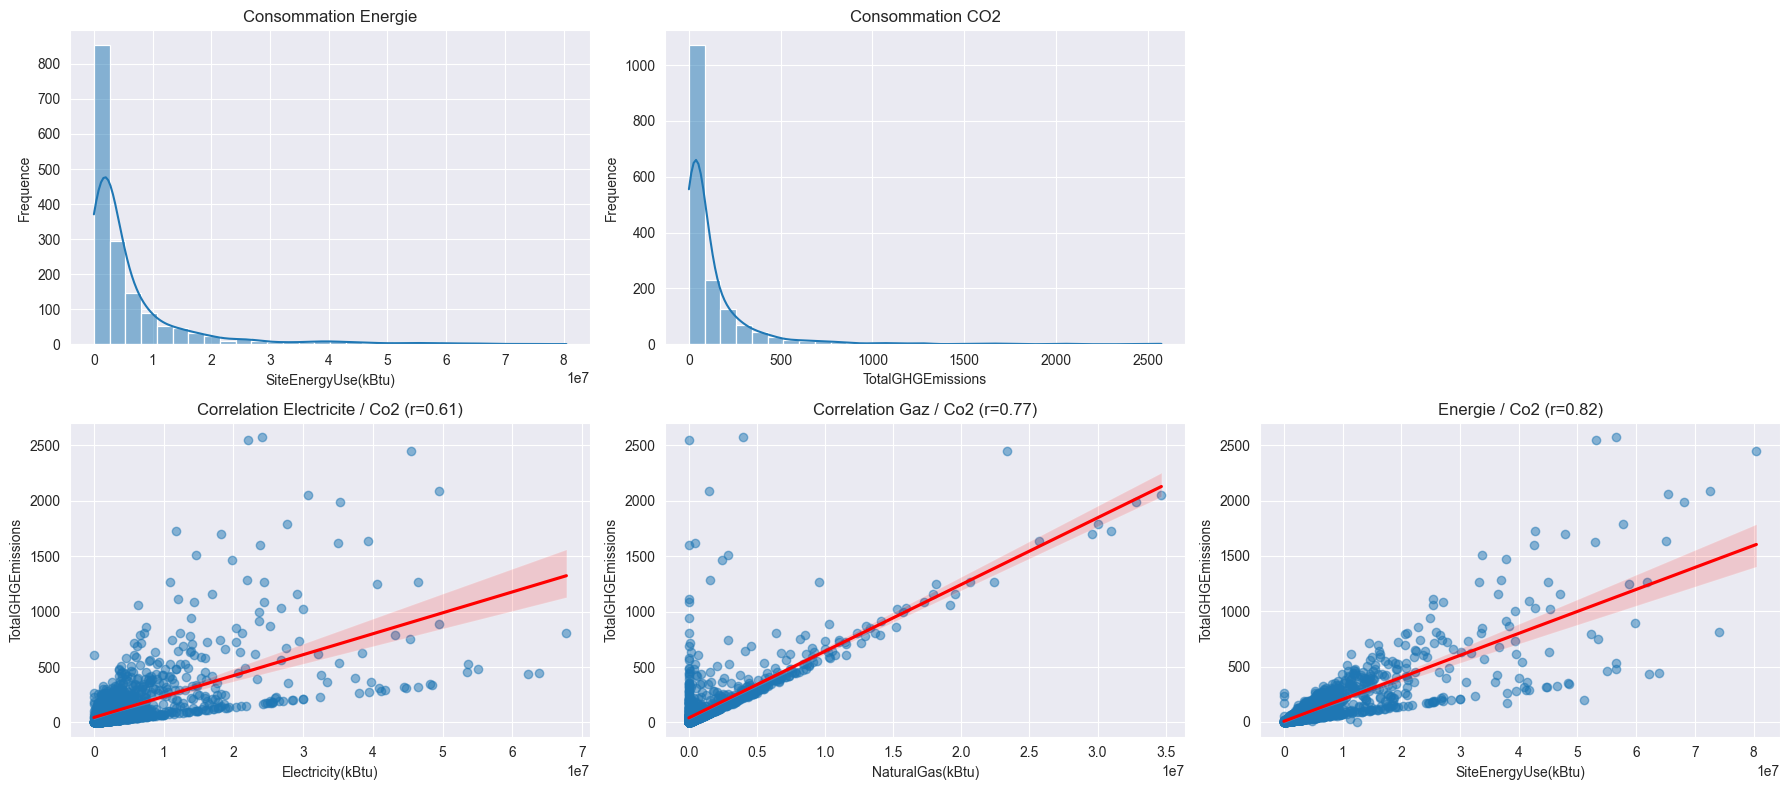

In [73]:
from scipy.stats import pearsonr

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Histogramme énergie
sns.histplot(bc['SiteEnergyUse(kBtu)'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title("Consommation Energie")
axes[0, 0].set_xlabel("SiteEnergyUse(kBtu)")
axes[0, 0].set_ylabel("Frequence")

# Histogramme CO2
sns.histplot(bc['TotalGHGEmissions'], kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set_title("Consommation CO2")
axes[0, 1].set_xlabel("TotalGHGEmissions")
axes[0, 1].set_ylabel("Frequence")

axes[0, 2].axis("off")

# Scatter Electricité / CO2
r, p = pearsonr(bc['Electricity(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='Electricity(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[1, 0], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 0].set_title(f"Correlation Electricite / Co2 (r={r:.2f})")

# Scatter Gaz / CO2
r, p = pearsonr(bc['NaturalGas(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='NaturalGas(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[1, 1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 1].set_title(f"Correlation Gaz / Co2 (r={r:.2f})")

# Scatter Energie / CO2
r, p = pearsonr(bc['SiteEnergyUse(kBtu)'], bc['TotalGHGEmissions'])
sns.regplot(x='SiteEnergyUse(kBtu)', y='TotalGHGEmissions', data=bc, ax=axes[1, 2], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1, 2].set_title(f"Energie / Co2 (r={r:.2f})")

plt.tight_layout()
plt.show()

## Nettoyage des colonnes redondantes
* En utilisant une matrice de corrélation de Pearson.
* Graphique Heatmap de la librairie Seaborn

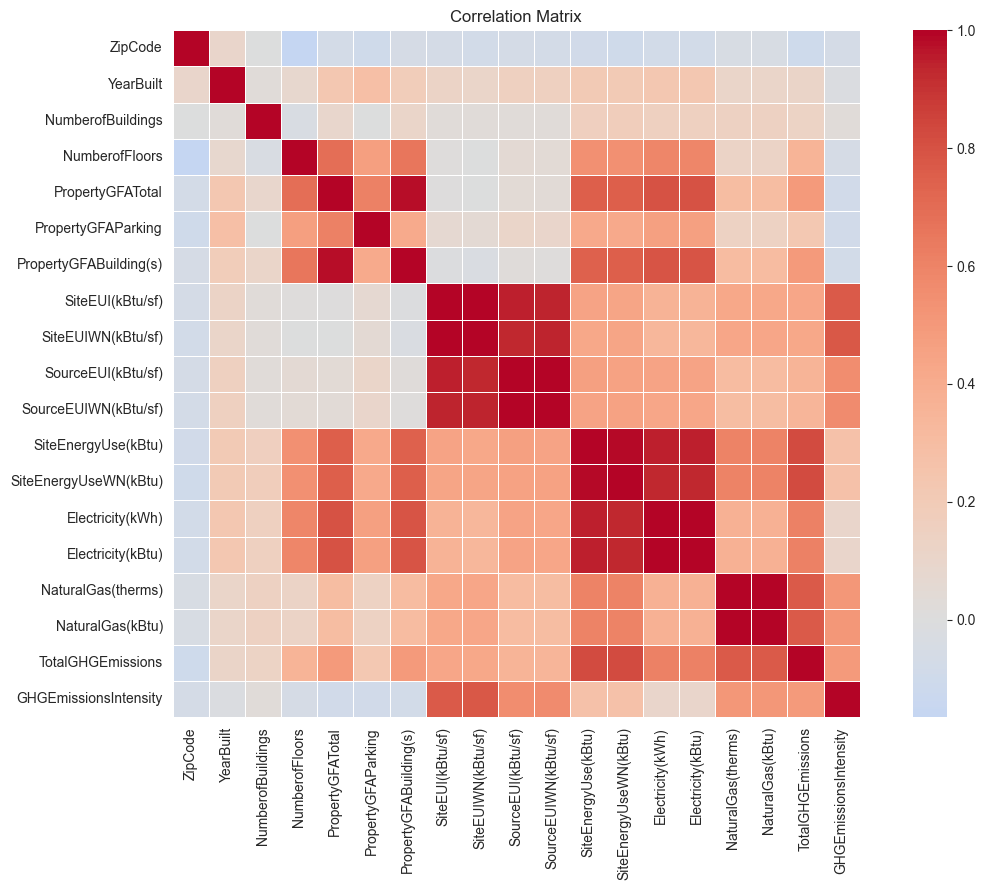

In [75]:
numeric_cols = bc.select_dtypes(include=[np.number])
corrmat = numeric_cols.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,
           cmap='coolwarm',      # Better color scheme for correlations
           center=0,             # Center colormap at 0
           square=True,
           linewidths=0.5)       # Add grid lines
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



In [ ]:
var = 'YearBuilt'
data = pd.concat([bc['SiteEnergyUse(kBtu)'], bc[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SiteEnergyUse(kBtu)", data=data)
fig.axis(ymin=0, ymax=80000000)
plt.xticks(rotation=90)
plt.show()

var = 'YearBuilt'
data = pd.concat([bc['TotalGHGEmissions'], bc[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="TotalGHGEmissions", data=data)
fig.axis(ymin=0, ymax=3000)
plt.xticks(rotation=90)
plt.show()

import scipy.stats as stats
#bc['SiteEnergyUse(kBtu)'] = np.log(bc['SiteEnergyUse(kBtu)'])
res = stats.probplot(bc['SiteEnergyUse(kBtu)'], plot=plt)
plt.show()